In [1]:
import pandas as pd
import torch
import numpy as np

In [2]:
# Loss function: MSE
def loss_fn(target: torch.Tensor, network_output: torch.Tensor) -> torch.Tensor:
    return torch.mean(torch.square(target - network_output))

In [3]:
import sys
sys.path.append('..')

from utilities import linear_net

In [4]:
training_path = '../training_data/'
verification_path = '../verification_data/'
results_path = '../results/'
interpolating_for = 'sine_10pi'

# Interpolating experiment

1. Plot target function and $\mathcal{NN}$ once training has concluded.
2. Represent the training process to visualize convergence.

In [5]:
verification_data = pd.read_csv(f"{verification_path}/verification_{interpolating_for}_linspace_{1000}.csv")
xx = torch.tensor(verification_data['x'], dtype = torch.float32)[:, None]

In [10]:
n_inputs = [3, 9, 27, 81, 243, 729]
dimensions = [5, 10, 15, 20, 100, 200]
learning_rates = [-2, -3]

In [9]:
for dim in [5]:
    for lr_exp in [-2, -3]:
        for N in n_inputs:#[3, 9, 27, 81, 243, 729]:
            # Load data
            input_data = pd.read_csv(f"{training_path}/input_{interpolating_for}_linspace_{N}.csv")
            x = torch.tensor(input_data['x'], dtype = torch.float32, requires_grad=False)[:, None]
            target = torch.tensor(input_data['y'], dtype = torch.float32, requires_grad=False)[:, None]

            for use_sigmoid in [True]:#[True, False]:
                # Get net
                NN = linear_net.Net(dim, torch.nn.Sigmoid()) if use_sigmoid \
                    else linear_net.Net(dim, torch.nn.ReLU(0.2))
                net_type = 'sigmoid' if use_sigmoid else 'relu'
                
                # Get optimizer
                optimizer = torch.optim.Adam(NN.parameters(), lr=10**lr_exp)

                # Training phase
                loss_log = []
                it_counter = 0

                while True:
                    optimizer.zero_grad()
                    loss = loss_fn(target, NN(x))
                    loss_log += [loss.item()]

                    print(f'{it_counter}: n_input: {N}, dimension: {dim}, learning_rate: {lr_exp}, loss: {loss}\r', end='', flush=True)

                    if loss < 1e-6 or it_counter > 200000:
                        network_output = np.reshape(NN(xx).detach().numpy(), newshape=-1)
                        
                        pd.DataFrame(data = { 'x': verification_data['x'], 
                                            'y_target': verification_data['y'], 
                                            'y_nn': network_output})\
                                    .to_csv(f'{results_path}/training_performance_{interpolating_for}_input{N}_{net_type}_lr{lr_exp}_dim{dim}.csv',
                                            index=False)
                        pd.DataFrame(data = { 'loss': loss_log })\
                                    .to_csv(f'{results_path}/loss_{interpolating_for}_input{N}_{net_type}_lr{lr_exp}_dim{dim}.csv', index = False)
                        break
                    else:
                        loss.backward()
                        optimizer.step()
                        it_counter = it_counter + 1

Count number of parameters:

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

for dim in range(1, 200):
    Net = linear_net.Net(dim, torch.nn.Sigmoid())
    if count_parameters(Net) != 3 * dim + 1:
        print(count_parameters(Net), 3*dim+1)

Evaluate accuracy of the algorithm according to dimensionality, learning rate and number of inputs:

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create empty table
shape = (len(learning_rates), len(n_inputs), len(dimensions))
results = np.zeros(shape)

for l_index in range(len(learning_rates)):
    for n_index in range(len(n_inputs)):
        for d_index in range(len(dimensions)):
            n = n_inputs[n_index]
            d = dimensions[d_index]
            l = learning_rates[l_index]

            # Read csv file
            file_name = f"{results_path}training_performance_{interpolating_for}_input{n}_sigmoid_lr{l}_dim{d}.csv"
            df = pd.read_csv(file_name)

            # Do the computations we need
            subtraction = df['y_nn'] - df['y_target']
            size = len(subtraction)
            results[l_index, n_index, d_index] = ((subtraction ** 2).sum() / size) ** 0.5

Plot accuracy and error:

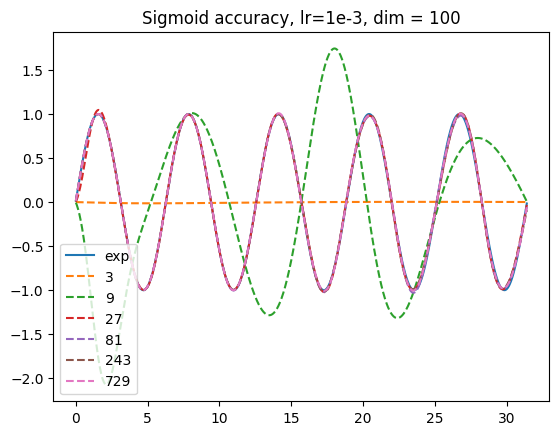

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

plt.plot(verification_data['x'], verification_data['y'], label = 'exp')
file_path = f'training_performance_{interpolating_for}_input'
for N in n_inputs:
    df = pd.read_csv(f'{results_path}{file_path}{N}_sigmoid_lr-3_dim100.csv')
    plt.plot(df['x'], df['y_nn'], label = N, linestyle='--')
plt.legend()
plt.title('Sigmoid accuracy, lr=1e-3, dim = 100')
plt.show()

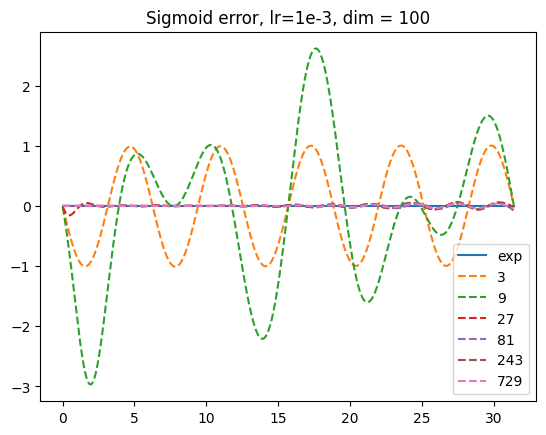

In [16]:
import matplotlib.pyplot as plt

plt.plot(verification_data['x'], 0 * verification_data['y'], label = 'exp')
file_path = f'training_performance_{interpolating_for}_input'
for N in n_inputs:
    df = pd.read_csv(f'{results_path}{file_path}{N}_sigmoid_lr-3_dim100.csv')
    plt.plot(df['x'], (df['y_nn'] - df['y_target']), label = N, linestyle='--')
plt.legend()
plt.title('Sigmoid error, lr=1e-3, dim = 100')
plt.show()

# Show results

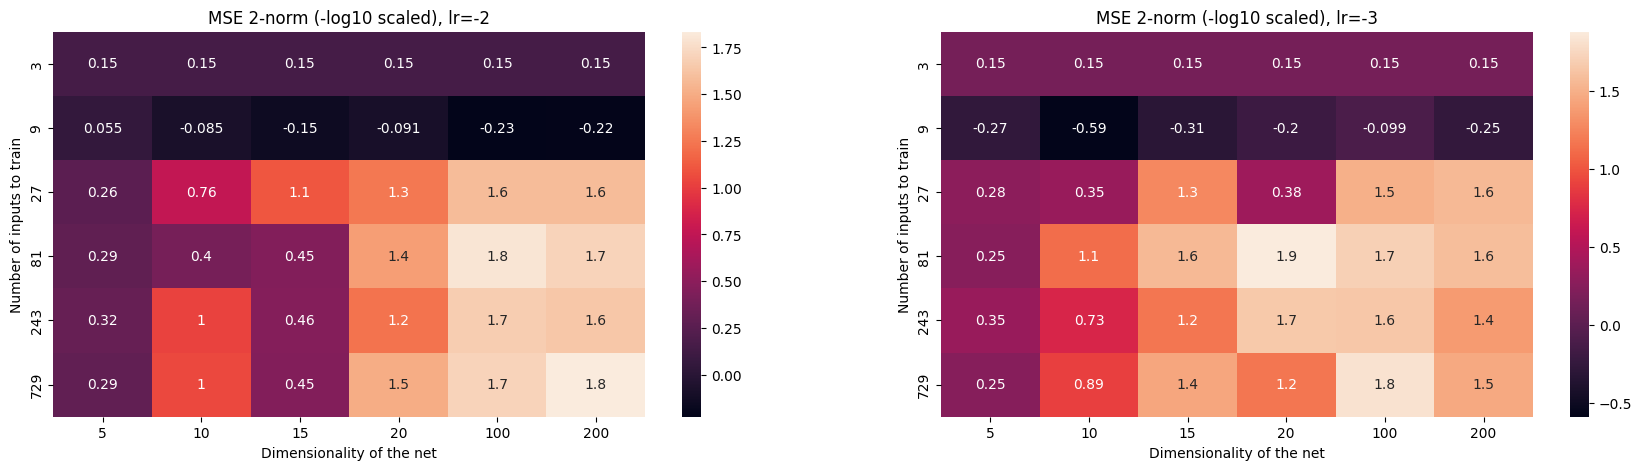

In [12]:
import seaborn
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (21, 5))
for ax_index in range(len(axes)):
    axes[ax_index].set_title(f'MSE 2-norm (-log10 scaled), lr={-(ax_index+2)}')

# x axis: dimension
# y axis: number of inputs

for idx in range(len(learning_rates)):
    input_data_sigmoid = -np.log10(results[idx]).reshape(len(n_inputs), len(dimensions))
    s = seaborn.heatmap(data = input_data_sigmoid, annot = input_data_sigmoid, 
                ax = axes[idx], xticklabels = dimensions, yticklabels = n_inputs)
    s.set(ylabel='Number of inputs to train', xlabel='Dimensionality of the net')

Loss function comparison

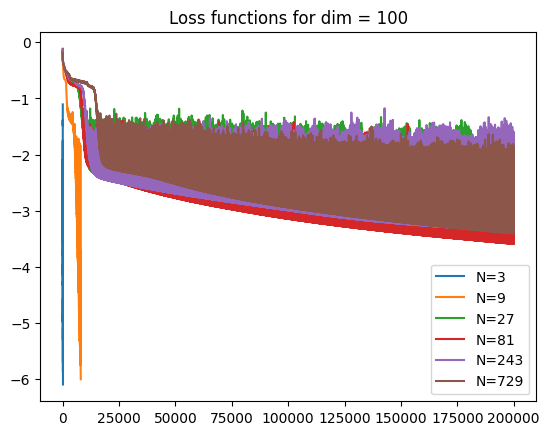

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

file_path = f'loss_{interpolating_for}_input'
for N in n_inputs:
    df = pd.read_csv(f'{results_path}{file_path}{N}_sigmoid_lr-2_dim100.csv')
    plt.plot(np.log10(df['loss']), label = f'N={N}')

plt.legend()
plt.title('Loss functions for dim = 100')
plt.show()

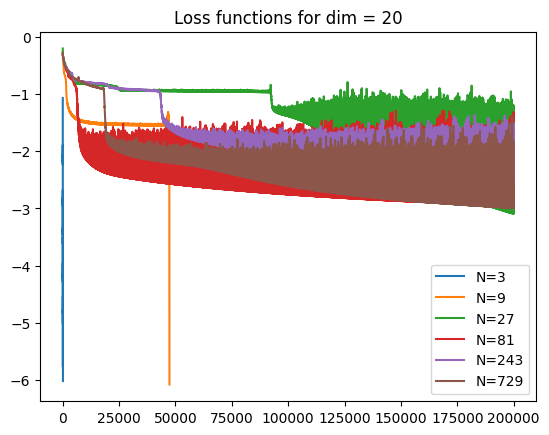

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

file_path = f'loss_{interpolating_for}_input'
for N in n_inputs:
    df = pd.read_csv(f'{results_path}{file_path}{N}_sigmoid_lr-2_dim20.csv')
    plt.plot(np.log10(df['loss']), label = f'N={N}')

plt.legend()
plt.title('Loss functions for dim = 20')
plt.show()

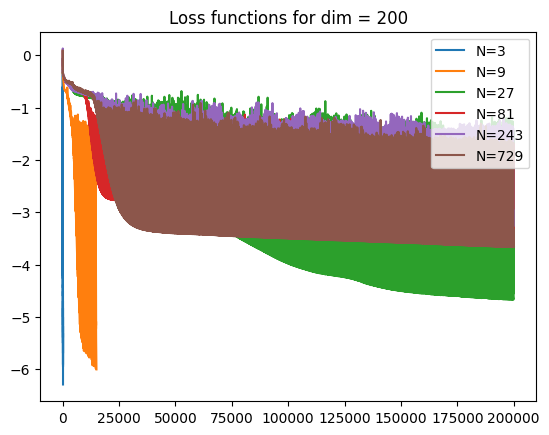

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

file_path = f'loss_{interpolating_for}_input'
for N in n_inputs:
    df = pd.read_csv(f'{results_path}{file_path}{N}_sigmoid_lr-2_dim200.csv')
    plt.plot(np.log10(df['loss']), label = f'N={N}')

plt.legend()
plt.title('Loss functions for dim = 200')
plt.show()